In [1]:
import sys
sys.path.insert(0, '../../../network')
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
from transfer_functions import ErrorFunction
from connectivity import ThresholdPlasticityRule
from scipy.stats import norm
from scipy.special import erf
from numpy import exp, sqrt, pi

In [2]:
mu = 0.22
sigma = 0.1
tau = 1e-2
dt = 1e-3
q_f = 0.8
x_f = abs(norm.ppf(1-q_f))

In [3]:
Acc, Asc, Ass, Acs = [5, 10, 5, 2] #Acc, Asc, Ass, Acs
y0 = [0, 1, 0, 0, 0, 1, 0, 0] # q_c1, q_c2, q_c3, q_c4, q_s1, q_s2, q_s3, q_s4
t = np.linspace(0, 1, 1001)
phi = lambda x: 0.5 * (1 + erf((x - mu) / (sqrt(2) * sigma)))
f = lambda x: np.where(x < x_f, -(1-q_f), q_f)
states = [f(0), f(1)]

In [4]:
def prob(etas, thres):
    ret = 1
    for eta in etas:
        if eta < 0: ret *= norm.cdf(thres)
        else: ret *= (1 - norm.cdf(thres))
    return ret 

def rate(y, t):
    Acc, Asc, Ass, Acs = [5, 10, 5, 2] 
    dydt = np.zeros(len(y))
    for i in range(len(y)):
        if i < 4:
            dydt[i] = ctx_dynamical_mft(y, i, Acc, Acs)
        else:
            dydt[i] = str_dynamical_mft(y, i, Ass, Asc)
    return dydt

In [5]:
def ctx_dynamical_mft(q, l, Acc, Acs, x_f=x_f, tau=1e-2):
    ret = 0
    states = [f(0), f(1)]
    for etas in [(p1, p2, p3, p4) for p1 in states for p2 in states for p3 in states for p4 in states]:
        ret += prob(etas, x_f) * etas[l] * phi(np.sum([etas[mu] * (Acc * q[mu] + Acs * q[mu+4]) for mu in range(4)]))
    return (-q[l] + ret)/tau

def str_dynamical_mft(q, l, Ass, Asc, x_f=x_f, tau=1e-2):
    ret = 0
    states = [f(0), f(1)]
    for etas in [(p1, p2, p3, p4) for p1 in states for p2 in states for p3 in states for p4 in states]:
        ret += prob(etas, x_f) * etas[l%4] * phi(np.sum([Ass * etas[mu] * q[mu+4] for mu in range(4)]) + 
                                               np.sum([Asc * etas[mu+1] * q[mu] for mu in range(3)]) +  Asc * etas[0] * q[3])
    return (-q[l] + ret)/tau 

In [6]:
import numpy as np

from scipy.integrate import solve_ivp

def exponential_decay(t, y): return -0.5 * y

sol = solve_ivp(exponential_decay, [0, 10], [2, 4, 8])

In [7]:
from scipy.integrate import odeint
sol = odeint(rate, y0, t)

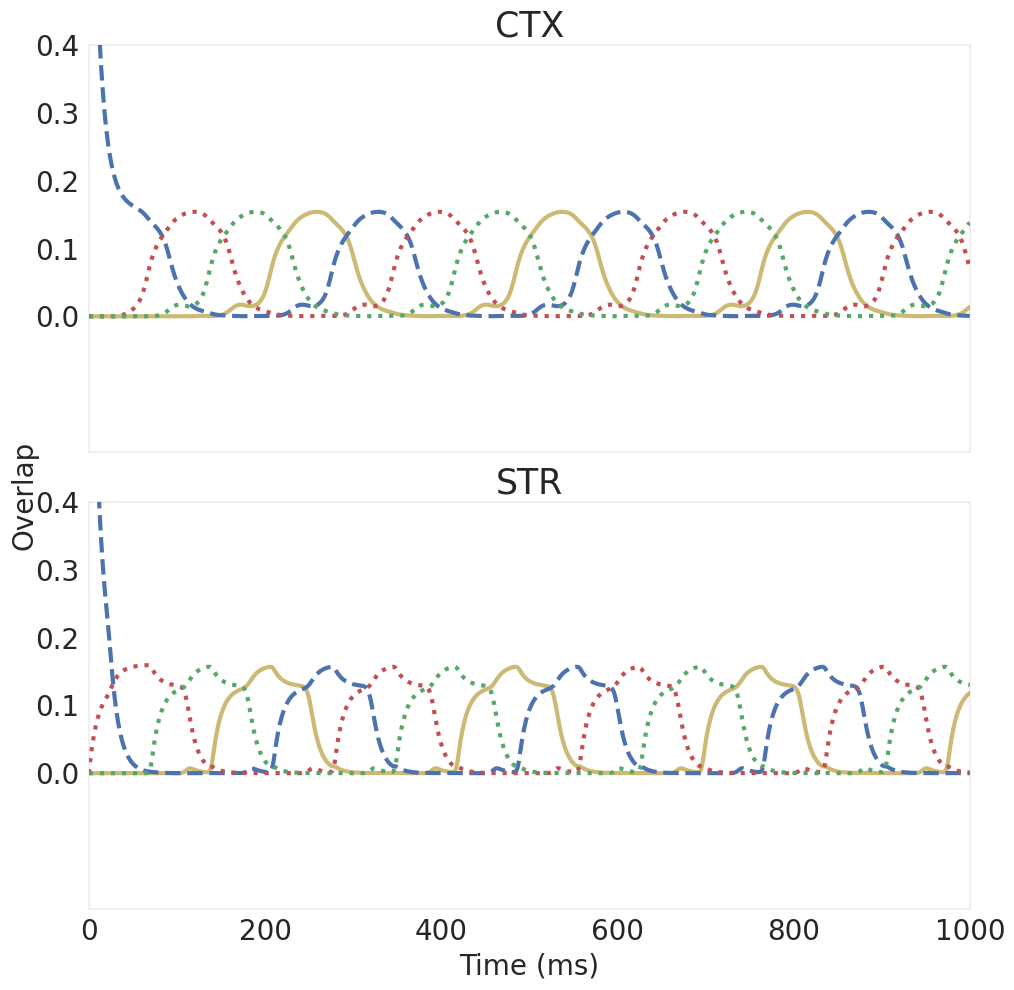

In [8]:
import seaborn as sns
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))
axes[0].plot(sol[:,0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(sol[:,1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(sol[:,2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(sol[:,3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)

axes[1].plot(sol[:,4], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(sol[:,5], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(sol[:,6], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(sol[:,7], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("STR", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[1].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0,1000))
plt.setp(axes, ylim=(-.2, .4))
# plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/MFT.jpg', bbox_inches = "tight", format='jpg')

plt.show()
